In [46]:
import MDAnalysis as mda
from MDAnalysis import transformations as trans

# directories to analyze
dirs = ['/home/zach/Documents/md/ftsb-perm-zn-aMD/aMD defaults/ftsb-perm/openmm_amd_dual/first_run/',
       '/home/zach/Documents/md/ftsb-perm-zn-aMD/aMD defaults/ftsb-perm/openmm_amd_dual/second_run/',
       '/home/zach/Documents/md/ftsb-perm-zn-aMD/aMD defaults/perm/openmm_amd_dual/']

swap_ftsb_perm = [True, True, False]

stride = 1 # interval between frames saved; change to 1 later

step1 = 20 # number of dcd in prerun
step2 = 100 # number of dcd in aMD
step3 = 100 # number of dcd in postrun

for i in range(len(dirs)):
    
    print('processing',i+1,'of',len(dirs),'data directories')
    f = dirs[i]
    
    # load initial conformation pdb and find protein atoms

    fNames = []
    for j in range(1, step1+1):
        fNames.append(f+'step6.7_aMD_prerun_'+str(j)+'.dcd')
    for j in range(1, step2+1):
        fNames.append(f+'step7_'+str(j)+'.dcd')
    for j in range(1, step3+1):
        fNames.append(f+'step8_aMD_postrun_'+str(j)+'.dcd')

    universe = mda.Universe(f+'step5_input.psf',fNames)

    # Correct misnaming segments in system
    if swap_ftsb_perm[i]:
        ftsb = universe.select_atoms("segid PERM")
        ftsb.segments.segids = 'temp'
        perm = universe.select_atoms("segid FTSB")
        perm.segments.segids = 'PERM'
        ftsb = universe.select_atoms("segid temp")
        ftsb.segments.segids = 'FTSB'

    protein = universe.select_atoms('protein')

    protein.write(f+'protein-only-initial-frame.pdb',frames=universe.trajectory[[0]])
    protein.write(f+'protein-only.dcd',frames=universe.trajectory[1::stride])

processing 1 of 1 data directories


In [106]:
# get hbond distance
import MDAnalysis.analysis.atomicdistances as ad
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda

# directories to analyze
dirs = ['/home/zach/Documents/md/ftsb-perm-zn-aMD/aMD defaults/ftsb-perm/openmm_amd_dual/first_run/',
       '/home/zach/Documents/md/ftsb-perm-zn-aMD/aMD defaults/ftsb-perm/openmm_amd_dual/second_run/']

swap_ftsb_perm = [True, True]

stride = 10 # interval between frames saved; change to 1 later

step1 = 20 # number of dcd in prerun
step2 = 100 # number of dcd in aMD
step3 = 100 # number of dcd in postrun

# TRP191 NE1 TYR239 OH
# TYR187 OH THR40 OG1
# TRP186 N GLN43 OE1

pairs = [ ['segid PERM and resid 239 and name OH', 'segid FTSB and resid 191 and name NE1'],
         ['segid PERM and resid 40 and name OG1', 'segid FTSB and resid 187 and name OH'],
         ['segid PERM and resid 43 and name OE1', 'segid FTSB and resid 186 and name N'] ]

distances = []

for i in range(len(dirs)):

    f = dirs[i]

    # load trajectory
    fNames = []
    for j in range(1, step1+1):
        fNames.append(f+'step6.7_aMD_prerun_'+str(j)+'.dcd')
    for j in range(1, step2+1):
        fNames.append(f+'step7_'+str(j)+'.dcd')
    for j in range(1, step3+1):
        fNames.append(f+'step8_aMD_postrun_'+str(j)+'.dcd')

    universe = mda.Universe(f+'step5_input.psf',fNames)

    if swap_ftsb_perm[i]:
        ftsb = universe.select_atoms("segid PERM")
        ftsb.segments.segids = 'temp'
        perm = universe.select_atoms("segid FTSB")
        perm.segments.segids = 'PERM'
        ftsb = universe.select_atoms("segid temp")
        ftsb.segments.segids = 'FTSB'

    # get distances for trajectory
    distances.append([])
    
    for j in range(len(pairs)):
    
        ag1 = universe.select_atoms(pairs[j][0])
        ag2 = universe.select_atoms(pairs[j][1])
        
        distances[-1].append(ad.AtomicDistances(ag1, ag2).run(step=1).results)


In [202]:
# Save distances

for i in range(2):
    for j in range(len(pairs)):
        p1 = pairs[j][0].split(' ')
        p2 = pairs[j][1].split(' ')
        fname = '_'.join(['distances_run'+str(i+1),p1[1],p1[4],p1[7],p2[1],p2[4],p2[7]]) + '.dat'
        np.savetxt(fname, distances[i][j])

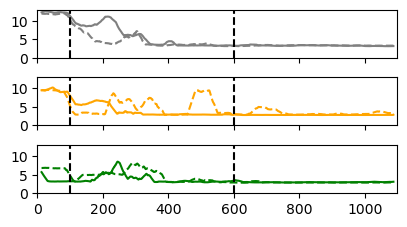

In [1]:
# Load from text and plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

pairs = [ ['segid PERM and resid 239 and name OH', 'segid FTSB and resid 191 and name NE1'],
         ['segid PERM and resid 40 and name OG1', 'segid FTSB and resid 187 and name OH'],
         ['segid PERM and resid 43 and name OE1', 'segid FTSB and resid 186 and name N'] ]

figure_prefix = '../figures/figure-1-figure-S1/perm-ftsb-hbonds/'
data_prefix = '../data/perm-ftsb-hbonds/'

# loading
distances = []
for i in range(2):
    distances.append([])
    for j in range(len(pairs)):
        p1 = pairs[j][0].split(' ')
        p2 = pairs[j][1].split(' ')
        fname = data_prefix + '_'.join(['distances_run'+str(i+1),p1[1],p1[4],p1[7],p2[1],p2[4],p2[7]]) + '.dat'
        distances[i].append(np.genfromtxt(fname))

dt = 0.1
t = np.arange(len(distances[0][0]))*dt
N = int(25/dt) # window size

cs = ['gray','orange','green']

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(4.1,2.3))
# fig.suptitle('Hydrogen bond distances')

plt.rcParams.update({'font.family': 'Arial', 'font.size': 7.5, 'font.weight': 'medium', 'font.style': 'normal'})
plt.rcParams['svg.fonttype'] = 'none'


for i in range(len(distances)):
    for j in range(len(pairs)):

        p1 = pairs[j][0].split(' ')
        p2 = pairs[j][1].split(' ')
        fname = '_'.join(['distances_run'+str(i+1),p1[1],p1[4],p1[7],p2[1],p2[4],p2[7]]) + '.dat'
        c = cs[j]
        if i:
            ls = '--'
        else:
            ls = '-'
        
        y_smooth = np.convolve(distances[i][j][:], np.ones((N,))/N, mode='same') 
        ax[j].plot(t[N//2:-(N-1-N//2)],y_smooth[N//2:-(N-1-N//2)],color=c,linestyle=ls)
        ax[j].set_xlim([0,1100])
        ax[j].set_ylim([0,13])

        ax[j].set_yticks([0,5,10])

        if i==1:
            ax[j].axvline(100,color='black',linestyle='--')
            ax[j].axvline(600,color='black',linestyle='--')

plt.tight_layout()
plt.savefig(figure_prefix + 'hbonds_figure_1e.png',dpi=300)
plt.savefig(figure_prefix + 'hbonds_figure_1e.svg',dpi=300)
